In [25]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import LSTM
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers import Dropout,BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import RMSprop, Adam


# Long Short-Term Memory Networks(LSTM)

There are three main signal types in the raw data: total acceleration, body acceleration, and body gyroscope. Each has 3 axises of data. This means that there are a total of nine variables for each time step.

Further, each series of data has been partitioned into overlapping windows of 2.56 seconds of data, or 128 time steps. These windows of data correspond to the windows of engineered features (rows) in the previous section.

This means that one row of data has (128 * 9), or 1,152 elements. This is a little less than double the size of the 561 element vectors in the previous section and it is likely that there is some redundant data.

In [26]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values


In [27]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [28]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [29]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + r'C:\Users\phaneendra.veguru\Desktop\ml\HarDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + r'C:\Users\phaneendra.veguru\Desktop\ml\HarDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy


In [30]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [34]:
# fit and evaluate a model

verbose, epochs, batch_size = 0, 25, 64

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)


 Accuracy 


In [37]:
print(accuracy)


0.9263657927513123


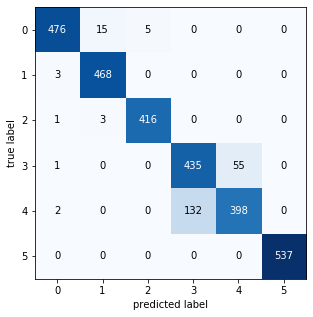

In [35]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testy,axis = 1)

CM = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(15, 5))
plt.show()

In [36]:
from sklearn.metrics import classification_report , accuracy_score
print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       496
           1       0.96      0.99      0.98       471
           2       0.99      0.99      0.99       420
           3       0.77      0.89      0.82       491
           4       0.88      0.75      0.81       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

